In [1]:
from preprocessing import *

import pandas as pd
import numpy as np
import gzip
import json
import os

from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from review_embeddings import get_embedding

[nltk_data] Downloading package punkt to /home/tianyiyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


torch.Size([1, 768])


[nltk_data] Downloading package punkt to /home/tianyiyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
def count_regex_match(dataset: pd.DataFrame, column: str, regex: str):
    return dataset[column].str.contains(regex).sum()

In [2]:
food_dataset = getAmazonData('food')

In [24]:
tmp = food_dataset[(food_dataset.reviewText == " ") | (food_dataset.reviewText.isnull()) | (food_dataset.reviewText == "  ") ]

In [26]:
grouped_text = tmp.groupby('reviewerID').agg(
    {"reviewText": len}
)

In [31]:
grouped_text[grouped_text.reviewText == 1].value_counts()

reviewText
1             2053
dtype: int64

In [3]:
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()


In [5]:
food_dataset_notNull = food_dataset[food_dataset['reviewText'].notnull()]
df = food_dataset_notNull[food_dataset_notNull['overall'].notnull()]

In [6]:
grouped = df.groupby('reviewerID').agg(
    {
        'overall'   : lambda x: np.round(np.mean(list(x))),
        'reviewText': len
    }
)

In [66]:
heatmap_data_cold = np.empty((5, 5))
for num_review in range(1,6):
    for rating in range(1,6):
        heatmap_data[num_review-1, rating-1] = len(grouped[(grouped.overall == rating) & (grouped.reviewText == num_review)])

heatmap_data_warm = np.empty((10, 5))
for num_review in range(6, 16):
    for rating in range(1,6):
        heatmap_data[num_review-6, rating-1] = len(grouped[(grouped.overall == rating) & (grouped.reviewText == num_review)])

/home/tianyiyang/miniconda3/envs/696ds/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/tianyiyang/miniconda3/envs/696ds/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


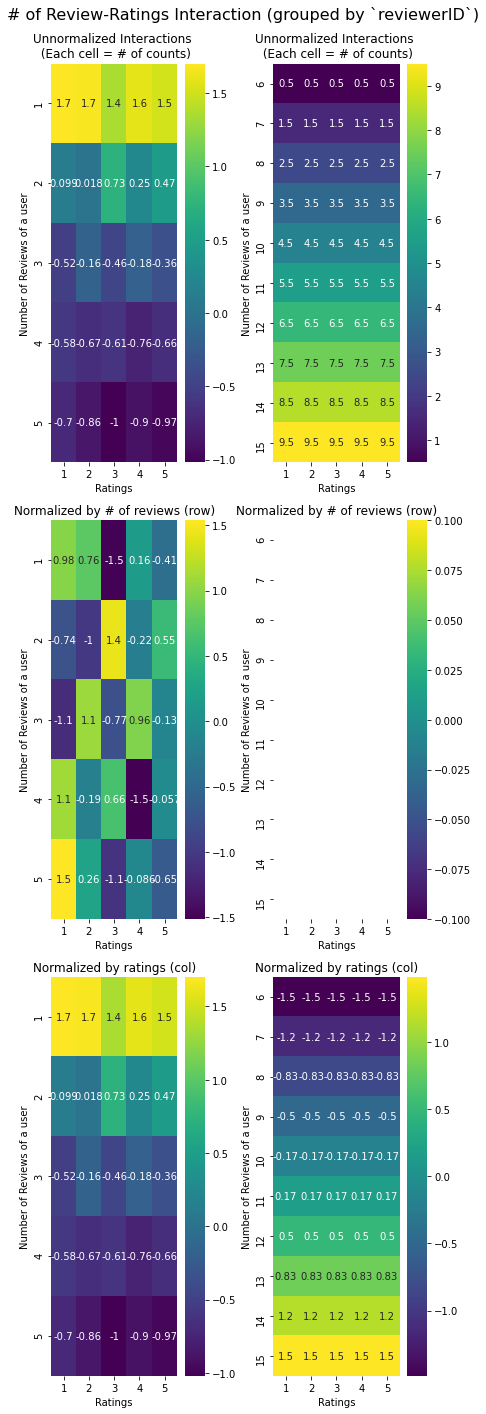

In [67]:
fig, axes = plt.subplots(3,2,figsize=(13, 20))
fig.suptitle("# of Review-Ratings Interaction (grouped by `reviewerID`)\n", fontsize=16)

cold_Index= [str(i) for i in range(1, 6)]
cold_Cols = [str(i) for i in range(1,6)]
df_cold = pd.DataFrame(heatmap_data_cold, index=cold_Index, columns=cold_Cols)
df_cold_norm_row = df_cold.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
df_cold_norm_col=(df_cold-df_cold.mean())/df_cold.std()

warm_Index= [str(i) for i in range(6, 16)]
warm_Cols = [str(i) for i in range(1,6)]
df_warm = pd.DataFrame(heatmap_data_warm, index=warm_Index, columns=warm_Cols)
df_warm_norm_row = df_warm.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
df_warm_norm_col=(df_warm-df_warm.mean())/df_warm.std()

sns.heatmap(df_cold, cmap='viridis', annot=True, ax=axes[0,0])
axes[0,0].set_title("Unnormalized Interactions \n (Each cell = # of counts)")
axes[0,0].set_xlabel("Ratings")
axes[0,0].set_ylabel("Number of Reviews of a user")
sns.heatmap(df_warm, cmap='viridis', annot=True, ax=axes[0,1])
axes[0,1].set_title("Unnormalized Interactions \n (Each cell = # of counts)")
axes[0,1].set_xlabel("Ratings")
axes[0,1].set_ylabel("Number of Reviews of a user")

sns.heatmap(df_cold_norm_row, cmap='viridis', annot=True, ax=axes[1,0])
axes[1,0].set_title("Normalized by # of reviews (row)")
axes[1,0].set_xlabel("Ratings")
axes[1,0].set_ylabel("Number of Reviews of a user")
sns.heatmap(df_warm_norm_row, cmap='viridis', annot=True, ax=axes[1,1])
axes[1,1].set_title("Normalized by # of reviews (row)")
axes[1,1].set_xlabel("Ratings")
axes[1,1].set_ylabel("Number of Reviews of a user")

sns.heatmap(df_cold_norm_col, cmap='viridis', annot=True, ax=axes[2,0])
axes[2,0].set_title("Normalized by ratings (col)")
axes[2,0].set_xlabel("Ratings")
axes[2,0].set_ylabel("Number of Reviews of a user")
sns.heatmap(df_warm_norm_col, cmap='viridis', annot=True, ax=axes[2,1])
axes[2,1].set_title("Normalized by ratings (col)")
axes[2,1].set_xlabel("Ratings")
axes[2,1].set_ylabel("Number of Reviews of a user")
fig.tight_layout() 

# plt.savefig('review_rating_interactions.png', bbox_inches='tight')

In [8]:
grouped = df.groupby('reviewerID').agg(
    {'overall': lambda x: np.mean(list(x))}
)

In [92]:
df = food_dataset[food_dataset['overall'].notnull()]
grouped = df.groupby('reviewerID').agg(
    {'reviewText': len}
)

<ipython-input-106-0940b71b116d>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[1,0].set_xticks(range(1,11), [str(i) for i in range(1,11)])


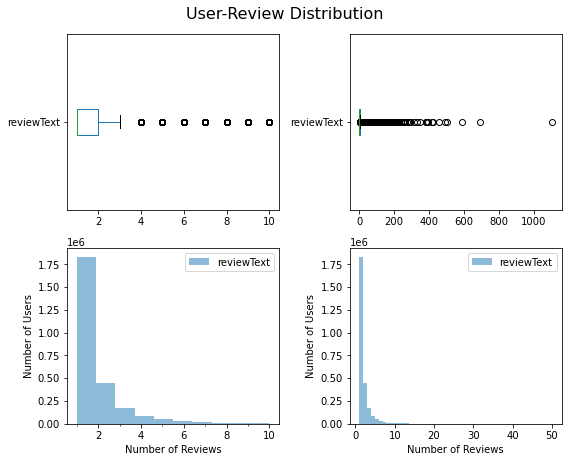

In [106]:
# make a list of all dataframes 
fig, axes = plt.subplots(2, 2,figsize=(8,6.5))

fig.suptitle("User-Review Distribution", fontsize=16)
grouped[grouped <= 10].plot.box(vert=False, ax=axes[0,0])
# axes[0,0].set_yticklabels("")
grouped.plot.box(vert=False, ax=axes[0,1])
# axes[0,1].set_yticklabels("")
grouped[grouped <= 10].plot.hist(bins=10, alpha=0.5, ax=axes[1,0])
axes[1,0].set_xlabel("Number of Reviews")
axes[1,0].set_ylabel("Number of Users")
axes[1,0].set_xticks(range(1,11), [str(i) for i in range(1,11)])
grouped[grouped <= 50].plot.hist(bins=50, alpha=0.5, ax=axes[1,1])
axes[1,1].set_xlabel("Number of Reviews")
axes[1,1].set_ylabel("Number of Users")
fig.tight_layout() 

plt.savefig('user_review_distribution.png', bbox_inches='tight')

<ipython-input-91-8d44be9119df>:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[0].set_xticks(range(1,6), [str(i) for i in range(1,6)])
<ipython-input-91-8d44be9119df>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes[1].set_xticks(range(1,6), [str(i) for i in range(1,6)])


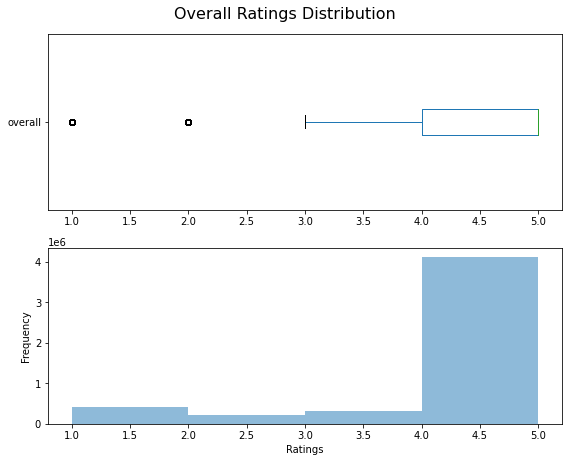

In [91]:
# make a list of all dataframes 
fig, axes = plt.subplots(2, 1,figsize=(8,6.5))

fig.suptitle("Overall Ratings Distribution", fontsize=16)
df = food_dataset[food_dataset['overall'].notnull()]
df['overall'].plot.box(vert=False, ax=axes[0])
axes[0].set_xticks(range(1,6), [str(i) for i in range(1,6)])
df['overall'].plot.hist(bins=4, alpha=0.5, ax=axes[1])
axes[1].set_xticks(range(1,6), [str(i) for i in range(1,6)])
axes[1].set_xlabel("Ratings")
fig.tight_layout() 
plt.savefig('ratings_distribution.png', bbox_inches='tight')

In [ ]:
sentence_counts = food_dataset_notNull['reviewText'].apply(
    lambda x: len(tokenizer.tokenize(str(x)))
)

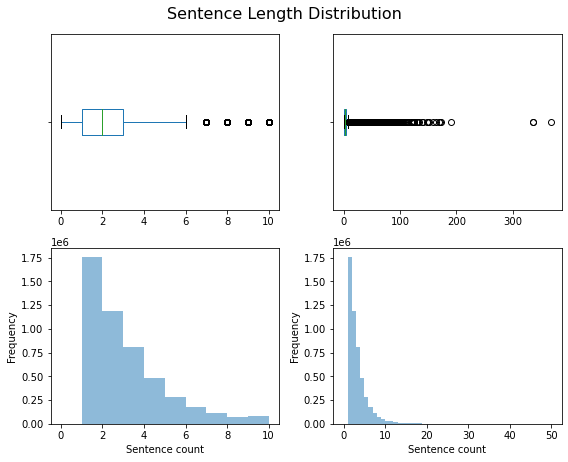

In [67]:
# make a list of all dataframes 
fig, axes = plt.subplots(2, 2,figsize=(8,6.5))

fig.suptitle("Sentence Length Distribution", fontsize=16)
sentence_counts[sentence_counts <= 10].plot.box(vert=False, ax=axes[0,0])
axes[0,0].set_yticklabels("")
sentence_counts.plot.box(vert=False, ax=axes[0,1])
axes[0,1].set_yticklabels("")
sentence_counts[sentence_counts <= 10].plot.hist(bins=10, alpha=0.5, ax=axes[1,0])
axes[1,0].set_xlabel("Sentence count")
sentence_counts[sentence_counts <= 50].plot.hist(bins=50, alpha=0.5, ax=axes[1,1])
axes[1,1].set_xlabel("Sentence count")
fig.tight_layout() 
plt.savefig('sentence_length_distribution.png', bbox_inches='tight')

In [31]:
with pd.option_context('display.max_colwidth', None):
    print(food_dataset_notNull[sentence_counts==sentence_counts.max()].reviewText)

87494    I'm not a member of the food police. However; I get really mad when a company short changes their customers hoping they will not notice. ESPECIALLY a supposed higher end "GOURMET" producer like Ghirardelli!\n\nThe quick and dirty for those who don't want to read my detailed review.\n\n**Is it better than "Swiss Miss," YES.\n\n**Did it used to be better before they over-sweetened, cut the # of servings from 20 to 12 and generally ruined a decent product? YES!\n\n**Is it over-priced and resting on the Ghirardelli name? OH YES.\n\n**Is it a way to impress people who don't know any better albiet for a price? Probably.\n\n**Do I still recommend Ghirardelli Hot Chocolates. NOPE Not Any More. (want to know why? read on)\n\nFor years I have enjoyed the Ghirardelli line of hot chocolates. That is about to change!\n\nNOTE: Until this year they have born the subtitle "Old Fashioned." That designation has been dropped for reasons which will soon become apparent. They have also quite consp

In [53]:
sentence_counts = food_dataset_notNull['reviewText'].apply(
    lambda x: len(tokenizer.tokenize(str(x)))
).sum()

sentence_length = food_dataset_notNull['reviewText'].apply(
    lambda x: sum([len(i) for i in tokenizer.tokenize(str(x))])
).sum()

# food_dataset_notNull.groupby('reviewerID').agg(
#     {"reviewText": len}
# )['reviewText'].mean()


In [56]:
sentence_length /sentence_counts

59.25441657885446

# Dataset: `Grocery_and_Gourmet_Food`

## Overview
* Dataset name: Grocery_and_Gourmet_Food.json.gz
* Dataset size: 5074160
* Dataset columns:
    * `'overall'`: rating of the product
        - Unique: 5
        - max: 5.0, mean: 4.314708247276396, min: 1.0
    * `'verified'`
        - Unique: 2
    * `'reviewTime'`: time of the review (raw)
        - Unique: 5221
    * `'reviewerID'`: ID of the reviewer
        - Unique: 2695974
    * `'asin'`: ID of the product
        - Unique: 283507
    * `'reviewerName'`: name of the reviewer
        - Unique: 1624950
    * `'reviewText'`: text of the review
        - Unique: 4181957
    * `'summary'`: summary of the review
        - Unique: 2181742
    * `'unixReviewTime'`:  time of the review (unix time)
        - Unique: 5221
        - max: 1538870400, mean: 1446592262.935343, min: 961372800
    * `'vote'`: helpful votes of the review
        - Unique: 574
    * `'image'`: images that users post after they have received the product
        - Total: 70935
    * `'style'`: a disctionary of the product metadata, e.g., "Format" is "Hardcover"
        - Total: 2275324

In [27]:
describe_dataset('food', food_dataset)

Dataset name: Grocery_and_Gourmet_Food.json.gz
Dataset size: 5074160
Dataset columns:
	'overall'--Unique: 5
         	--max: 5.0, mean: 4.314708247276396, min: 1.0
	'verified'--Unique: 2
	'reviewTime'--Unique: 5221
	'reviewerID'--Unique: 2695974
	'asin'--Unique: 283507
	'reviewerName'--Unique: 1624950
	'reviewText'--Unique: 4181957
	'summary'--Unique: 2181742
	'unixReviewTime'--Unique: 5221
                	--max: 1538870400, mean: 1446592262.935343, min: 961372800
	'vote'--Unique: 574
	'image'--Total: 70935
	'style'--Total: 2275324


## '* Star' Percentage
* **'Five stars': 1140877/5074160 (0.225)**
* **'\*\*\* stars': 1493472/5074160 (0.294)**

## Top 50 `summary` phrases (2-3 words):
* **[1139968]** `Five Stars       `    
* **[ 412668]** `Stars Five       `    
* **[ 412388]** `Stars Five Stars `    
* **[ 340168]** `Five Stars Five  `    
* **[ 148855]** `Four Stars       `    
* **[  79464]** `One Star         `    
* **[  74676]** `Three Stars      `    
* **[  73657]** `Stars Great      `    
* **[  61815]** `... Five         `    
* **[  61764]** `... Five Stars   `    
* **[  60431]** `Five Stars Great `    
* **[  53218]** `Stars Four       `    
* **[  53164]** `Stars Four Stars `    
* **[  51118]** `I love           `    
* **[  44327]** `Stars I          `    
* **[  43999]** `Two Stars        `    
* **[  42194]** `Five Stars Four  `    
* **[  41879]** `Four Stars Five  `    
* **[  36949]** `the best         `    
* **[  35780]** `Five Stars I     `    
* **[  35346]** `This is          `    
* **[  34940]** `Stars Good       `    
* **[  30129]** `of the           `    
* **[  28013]** `Five Stars Good  `    
* **[  27146]** `Stars One        `    
* **[  25640]** `Stars Three      `    
* **[  25566]** `Stars Three Stars`    
* **[  25346]** `for the          `    
* **[  25322]** `I have           `    
* **[  24715]** `Stars One Star   `    
* **[  24539]** `in the           `    
* **[  24485]** `a great          `    
* **[  24453]** `Stars Love       `    
* **[  23579]** `for a            `    
* **[  23264]** `is the           `    
* **[  23001]** `Love this        `    
* **[  22859]** `love this        `    
* **[  21460]** `Great for        `    
* **[  21151]** `is a             `    
* **[  20792]** `Stars The        `    
* **[  20656]** `Five Stars One   `    
* **[  20092]** `Five Stars Love  `    
* **[  19646]** `Three Stars Five `    
* **[  19615]** `Five Stars Three `    
* **[  19231]** `like the         `    
* **[  19145]** `Star Five        `    
* **[  19130]** `Star Five Stars  `    
* **[  19098]** `One Star Five    `    
* **[  18931]** `Stars This       `    
* **[  18884]** `I was            `    

In [7]:
# Find the number of "Five Stars"
five_stars = count_regex_match(food_dataset, 'summary', "^(f|F)ive (s|S)tar(s|.)?")

# Find the number of "*** Stars"
any_stars = count_regex_match(food_dataset, 'summary', "^[A-z0-5]+ (s|S)tar(s|.)?")

total_rows = len(food_dataset['summary'])

print(f"'Five stars': {five_stars}/{total_rows} ({five_stars/total_rows:.3f})")
print(f"'*** stars': {any_stars}/{total_rows} ({any_stars/total_rows:.3f})")

/home/tianyiyang/miniconda3/envs/696ds/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


'Five stars': 1140877/5074160 (0.225)
'*** stars': 1493472/5074160 (0.294)


In [9]:
summary_counter = top_phrases(food_dataset, 'summary', range(2,4), print_top50=True)

Five Stars           1139968
Stars Five            412668
Stars Five Stars      412388
Five Stars Five       340168
Four Stars            148855
One Star               79464
Three Stars            74676
Stars Great            73657
... Five               61815
... Five Stars         61764
Five Stars Great       60431
Stars Four             53218
Stars Four Stars       53164
I love                 51118
Stars I                44327
Two Stars              43999
Five Stars Four        42194
Four Stars Five        41879
the best               36949
Five Stars I           35780
This is                35346
Stars Good             34940
of the                 30129
Five Stars Good        28013
Stars One              27146
Stars Three            25640
Stars Three Stars      25566
for the                25346
I have                 25322
Stars One Star         24715
in the                 24539
a great                24485
Stars Love             24453
for a                  23579
is the        

## '* Star' Percentage
* **'Five stars': 8383/5074160 (0.002)**
* **'\*\*\* stars': 187481/5074160 (0.037)**

## Top 50 `reviewText` phrases (6-7 words):
* **[2658]**    `If you are looking for a                                                                           `    
* **[2513]**    `This is one of my favorite                                                                         `    
* **[2362]**    `This is by far the best                                                                            `    
* **[2268]**    `This is one of the best                                                                            `    
* **[1882]**    `a little goes a long way.                                                                          `    
* **[1801]**    `class="a-section a-spacing-small a-spacing-top-mini video-block"></div><input type="hidden" name=""`    
* **[1767]**    `with just the right amount of                                                                      `    
* **[1523]**    `this as a gift for my                                                                              `    
* **[1491]**    `I am not a fan of                                                                                  `    
* **[1427]**    `at a discount in exchange for                                                                      `    
* **[1418]**    `I received this product at a                                                                       `    
* **[1404]**    `A little goes a long way.                                                                          `    
* **[1400]**    `I was so happy to find                                                                             `    
* **[1398]**    `decided to give it a try.                                                                          `    
* **[1377]**    `if you are looking for a                                                                           `    
* **[1265]**    `I love the taste of this                                                                           `    
* **[1258]**    `I am a big fan of                                                                                  `    
* **[1236]**    `This is the first time I                                                                           `    
* **[1219]**    `I decided to give it a                                                                             `    
* **[1201]**    `I bought this as a gift                                                                            `    
* **[1179]**    `I don't have to worry about                                                                        `    
* **[1145]**    `I am very happy with this                                                                          `    
* **[1144]**    `exactly what I was looking for.                                                                    `    
* **[1124]**    `has just the right amount of                                                                       `    
* **[1085]**    `and this is by far the                                                                             `    
* **[1081]**    `I would recommend this product to                                                                  `    
* **[1079]**    `you get what you pay for.                                                                          `    
* **[1075]**    `this is one of the best                                                                            `    
* **[1034]**    `I used to be able to                                                                               `    
* **[1026]**    `a discount in exchange for my                                                                      `    
* **[1009]**    `this is by far the best                                                                            `    
* **[1002]**    `and just the right amount of                                                                       `    
* **[ 972]**    `have not been able to find                                                                         `    
* **[ 972]**    `I am a huge fan of                                                                                 `    
* **[ 966]**    `bought this as a gift for                                                                          `    
* **[ 957]**    `I have been using this product                                                                     `    
* **[ 946]**    `This was a gift for my                                                                             `    
* **[ 944]**    `This is by far my favorite                                                                         `    
* **[ 937]**    `I have not been able to                                                                            `    
* **[ 935]**    `and this is one of the                                                                             `    
* **[ 931]**    `have been using this product for                                                                   `    
* **[ 924]**    `at a discount in exchange for my                                                                   `    
* **[ 924]**    `received this product at a discount                                                                `    
* **[ 923]**    `This is the second time I                                                                          `    
* **[ 905]**    `I haven't been able to find                                                                        `    
* **[ 903]**    `I'm not a big fan of                                                                               `    
* **[ 893]**    `I bought this as a gift for                                                                        `    
* **[ 887]**    `is the first time I have                                                                           `    
* **[ 865]**    `discount in exchange for my honest                                                                 `    
* **[ 862]**    `I received this product at a discount                                                              `    

In [8]:
# Find the number of "Five Stars"
five_stars = count_regex_match(food_dataset, 'reviewText', "(f|F)ive (s|S)tar(s|.)?")

# Find the number of "*** Stars"
any_stars = count_regex_match(food_dataset, 'reviewText', "[A-z0-5]+ (s|S)tar(s|.)?")

total_rows = len(food_dataset['reviewText'])

print(f"'Five stars': {five_stars}/{total_rows} ({five_stars/total_rows:.3f})")
print(f"'*** stars': {any_stars}/{total_rows} ({any_stars/total_rows:.3f})")

'Five stars': 8383/5074160 (0.002)
'*** stars': 187481/5074160 (0.037)


In [10]:
reviewText_counter = top_phrases(food_dataset, 'reviewText', range(6,8), print_top50=True)

If you are looking for a                                                                               2658
This is one of my favorite                                                                             2513
This is by far the best                                                                                2362
This is one of the best                                                                                2268
a little goes a long way.                                                                              1882
class="a-section a-spacing-small a-spacing-top-mini video-block"></div><input type="hidden" name=""    1801
with just the right amount of                                                                          1767
this as a gift for my                                                                                  1523
I am not a fan of                                                                                      1491
at a discount in exchange fo

## Sentences Count
### `reviewText`
```
    Sentence Length   Counts
                1    1763655
                2    1187970
                3     805299
                4     485480
                5     285773
                6     174089
                7     109538
                8      71937
                9      48469
                10     33810
                11     24372
                12     17784
                13     13328
                14     10074
                15      7692
                16      6056
                17      4744
                18      3789
                19      2968
                20      2575
                21      2145
                22      1815
                23      1476
                24      1282
                25       999
                26       867
                27       740
                28       687
                29       595
                30       448
                32       378
                31       374
                33       338
                34       267
                35       242
                36       201
                37       179
                39       154
                38       147
                40       137
                42       114
                41       102
                44        94
                43        75
                45        70
                46        63
                47        62
                50        54
                48        53
                51        46
```
### `summary`
```
    Sentence Length    Counts
                  1   4685329
                  2    366183
                  3     19677
                  4      2425
                  5       367
                  6       101
                  7        31
                  0        17
                  9        16
                  8         8
                  10        3
                  11        1
                  12        1
                  28        1
```

In [64]:
temp = sentence_count(food_dataset, 'reviewText', True)

    Sentence Length   Counts
0                 1  1763655
1                 2  1187970
2                 3   805299
3                 4   485480
4                 5   285773
5                 6   174089
6                 7   109538
7                 8    71937
8                 9    48469
9                10    33810
10               11    24372
11               12    17784
12               13    13328
13               14    10074
14               15     7692
15               16     6056
16               17     4744
17               18     3789
18               19     2968
19               20     2575
20               21     2145
21               22     1815
22               23     1476
23               24     1282
24               25      999
25               26      867
26               27      740
27               28      687
28               29      595
29               30      448
30               32      378
31               31      374
32               33      338
33            

In [63]:
temp = sentence_count(food_dataset, 'summary', True)

    Sentence Length   Counts
0                 1  4685329
1                 2   366183
2                 3    19677
3                 4     2425
4                 5      367
5                 6      101
6                 7       31
7                 0       17
8                 9       16
9                 8        8
10               10        3
11               11        1
12               12        1
13               28        1


In [2]:
phone_dataset = getAmazonData('phone', 'all')

In [3]:
describe_dataset('phone', phone_dataset)

Dataset name: Grocery_and_Gourmet_Food.json.gz
Dataset size: 10063255
Dataset columns:
	'overall'--Unique: 5
         	--max: 5.0, mean: 3.933553308546787, min: 1.0
	'verified'--Unique: 2
	'reviewTime'--Unique: 6004
	'reviewerID'--Unique: 6211701
	'asin'--Unique: 589534
	'reviewerName'--Unique: 3374445
	'reviewText'--Unique: 8625404
	'summary'--Unique: 3980501
	'unixReviewTime'--Unique: 6004
                	--max: 1538697600, mean: 1440631763.666607, min: 941328000
	'vote'--Unique: 640
	'image'--Total: 182305
	'style'--Total: 5017134


In [4]:
summary_counter = top_phrases(phone_dataset, 'summary', range(2,4), print_top50=True)

Five Stars           1964723
Stars Five            703876
Stars Five Stars      703324
Five Stars Five       523638
Four Stars            389851
One Star              336914
Three Stars           199340
... Five              150728
... Five Stars        150591
for the               146392
Stars Four            140823
Stars Four Stars      140717
Stars Great           140640
Two Stars             137037
Stars One             112462
Stars One Star        109712
Five Stars Great      105721
Five Stars Four       101267
Four Stars Five       100621
I love                 97493
Stars I                90579
Five Stars One         76067
my phone               74329
Star Five              73765
Star Five Stars        73703
One Star Five          73640
this case              73307
Stars Three            70030
Stars Three Stars      69887
for my                 68815
case for               67422
Five Stars I           65935
Stars Good             61845
for a                  60636
is a          

In [5]:
reviewText_counter = top_phrases(phone_dataset, 'reviewText', range(6,8), print_top50=True)

I received this product at a                                                                           14505
you get what you pay for.                                                                              12033
at a discount in exchange for                                                                          11826
received this product at a discount                                                                     9346
I received this product at a discount                                                                   8475
I bought this case for my                                                                               8135
a discount in exchange for my                                                                           8000
dropped my phone a few times                                                                            7981
exactly what I was looking for.                                                                         7748
class="a-section a-